## 0) Intro -  Objective 
The goal of this competition is to predict monthly microbusiness density in a given area. You will develop an accurate model trained on U.S. county-level data.
Your work will help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.

## 1) Import of packages

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import GroupKFold


from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)


import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#!pip install -U seaborn

data/census_starter.csv
data/test.csv
data/train.csv


In [5]:
pwd

'C:\\Users\\incar\\PycharmProjects\\Kaggle-Microbusiness-Density-Forecasting'

## 2) Load the data and check structure

In [11]:
train_data = pd.read_csv("data/train.csv", index_col='row_id')
test_data = pd.read_csv("data/test.csv", index_col='row_id')
census_data = pd.read_csv("data/census_starter.csv")

# Kaggle version
# train_data = pd.read_csv("../input/tabular-playground-series-sep-2022/train.csv", index_col='row_id')
# test_data = pd.read_csv("../input/tabular-playground-series-sep-2022/test.csv", index_col='row_id')

train_data.head()
# Test data does not contain the target variable (Survived)

# Convert the date column to datetime type
# train_data.date = pd.to_datetime(train_data.date)
# test_data.date = pd.to_datetime(test_data.date)

cfips          county    state first_day_of_month  \
row_id                                                               
1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

                 microbusiness_density  active  
row_id                                          
1001_2019-08-01               3.007682    1249  
1001_2019-09-01               2.884870    1198  
1001_2019-10-01               3.055843    1269  
1001_2019-11-01               2.993233    1243  
1001_2019-12-01               2.993233    1243

In [8]:
test_data.head()


cfips first_day_of_month
row_id                                   
1001_2022-11-01   1001         2022-11-01
1003_2022-11-01   1003         2022-11-01
1005_2022-11-01   1005         2022-11-01
1007_2022-11-01   1007         2022-11-01
1009_2022-11-01   1009         2022-11-01

In [12]:
census_data.head()

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  cfips  \
0         76.6         78.9         80.6         82.7         85.5   1001   
1         74.5         78.1         81.8         85.1         87.9   1003   
2         57.2         60.4         60.5         64.6         64.6   1005   
3         62.0         66.1         69.2         76.1         74.6   1007   
4         65.8         68.5         73.0         79.6         81.0   1009   

   pct_college_2017  pct_college_2018  pct_college_2019  pct_college_2020  \
0              14.5              15.9              16.1              16.7   
1              20.4              20.7              21.0              20.2   
2               7.6               7.8               7.6               7.3   
3               8.1               7.6               6.5               7.4   
4               8.7               8.1               8.6               8.9   

   ...  pct_it_workers_2017  pct_it_workers_2018  pct_it_workers_2019  \
0  ...                  1.3                  1.1                  0.7   
1  ...                  1.4                  1.3                  1.4   
2  ...                  0.5                  0.3                  0.8   
3  ...                  1.2                  1.4                  1.6   
4  ...                  1.3                  1.4                  0.9   

   pct_it_workers_2020  pct_it_workers_2021  median_hh_inc_2017  \
0                  0.6                  1.1               55317   
1                  1.0                  1.3               52562   
2                  1.1                  0.8               33368   
3                  1.7                  2.1               43404   
4                  1.1                  0.9               47412   

   median_hh_inc_2018  median_hh_inc_2019  median_hh_inc_2020  \
0             58786.0               58731             57982.0   
1             55962.0               58320             61756.0   
2             34186.0               32525             34990.0   
3             45340.0               47542             51721.0   
4             48695.0               49358             48922.0   

   median_hh_inc_2021  
0             62660.0  
1             64346.0  
2             36422.0  
3             54277.0  
4             52830.0  

[5 rows x 26 columns]

In [13]:
census_data.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

In [62]:
train_data.shape #check size of the train dataframe

(122265, 7)

In [33]:
train_data.info()  #check types of columns and non-null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.2+ MB


# Let's try to merge census data with the train data

In [18]:
train_data['year'] = train_data.first_day_of_month.str[0:4]

In [19]:
train_data

cfips          county    state first_day_of_month  \
row_id                                                                
1001_2019-08-01    1001  Autauga County  Alabama         2019-08-01   
1001_2019-09-01    1001  Autauga County  Alabama         2019-09-01   
1001_2019-10-01    1001  Autauga County  Alabama         2019-10-01   
1001_2019-11-01    1001  Autauga County  Alabama         2019-11-01   
1001_2019-12-01    1001  Autauga County  Alabama         2019-12-01   
...                 ...             ...      ...                ...   
56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

                  microbusiness_density  active  year  
row_id                                                 
1001_2019-08-01                3.007682    1249  2019  
1001_2019-09-01                2.884870    1198  2019  
1001_2019-10-01                3.055843    1269  2019  
1001_2019-11-01                2.993233    1243  2019  
1001_2019-12-01                2.993233    1243  2019  
...                                 ...     ...   ...  
56045_2022-06-01               1.803249     101  2022  
56045_2022-07-01               1.803249     101  2022  
56045_2022-08-01               1.785395     100  2022  
56045_2022-09-01               1.785395     100  2022  
56045_2022-10-01               1.785395     100  2022  

[122265 rows x 7 columns]

In [20]:
census_data.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

In [27]:
all_other = list(set(census_data.columns) - set(pct_foreign_born))
year_list=list(census_data.columns)


In [44]:
census_vars = ["pct_foreign_born", "pct_bb", "pct_college", "pct_it_workers", "median_hh_inc"]

In [61]:
df_list = []
for var in census_vars:
    var_list = [x for x in census_data.columns if var in x]
    df_var = pd.melt(census_data, id_vars = "cfips", var_name = "year", value_vars=var_list,value_name=var, ignore_index=False)
    df_var.year = df_var.year.str[-4:]
    df_list.append(df_var)

df_census = pd.concat(df_list, axis = 1).T.drop_duplicates().T
df_census

cfips  year pct_foreign_born pct_bb pct_college pct_it_workers  \
0      1001  2017              2.1   76.6        14.5            1.3   
1      1003  2017              3.2   74.5        20.4            1.4   
2      1005  2017              2.7   57.2         7.6            0.5   
3      1007  2017              1.0   62.0         8.1            1.2   
4      1009  2017              4.5   65.8         8.7            1.3   
...     ...   ...              ...    ...         ...            ...   
3137  56037  2021              5.5   88.4        12.4            1.0   
3138  56039  2021             11.1   90.5        38.3            2.0   
3139  56041  2021              2.9   90.6        12.3            0.9   
3140  56043  2021              1.0   85.4        17.2            1.1   
3141  56045  2021              1.6   81.3        13.9            0.0   

     median_hh_inc  
0          55317.0  
1          52562.0  
2          33368.0  
3          43404.0  
4          47412.0  
...            ...  
3137       76668.0  
3138       94498.0  
3139       75106.0  
3140       62271.0  
3141       65566.0  

[15710 rows x 7 columns]

In [64]:
new_df = pd.merge(train_data, df_census,  how='left', left_on=['cfips','year'], right_on = ['cfips','year'])
new_df

cfips          county    state first_day_of_month  \
0        1001  Autauga County  Alabama         2019-08-01   
1        1001  Autauga County  Alabama         2019-09-01   
2        1001  Autauga County  Alabama         2019-10-01   
3        1001  Autauga County  Alabama         2019-11-01   
4        1001  Autauga County  Alabama         2019-12-01   
...       ...             ...      ...                ...   
122260  56045   Weston County  Wyoming         2022-06-01   
122261  56045   Weston County  Wyoming         2022-07-01   
122262  56045   Weston County  Wyoming         2022-08-01   
122263  56045   Weston County  Wyoming         2022-09-01   
122264  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  year pct_foreign_born pct_bb  \
0                    3.007682    1249  2019              2.3   80.6   
1                    2.884870    1198  2019              2.3   80.6   
2                    3.055843    1269  2019              2.3   80.6   
3                    2.993233    1243  2019              2.3   80.6   
4                    2.993233    1243  2019              2.3   80.6   
...                       ...     ...   ...              ...    ...   
122260               1.803249     101  2022              NaN    NaN   
122261               1.803249     101  2022              NaN    NaN   
122262               1.785395     100  2022              NaN    NaN   
122263               1.785395     100  2022              NaN    NaN   
122264               1.785395     100  2022              NaN    NaN   

       pct_college pct_it_workers median_hh_inc  
0             16.1            0.7       58731.0  
1             16.1            0.7       58731.0  
2             16.1            0.7       58731.0  
3             16.1            0.7       58731.0  
4             16.1            0.7       58731.0  
...            ...            ...           ...  
122260         NaN            NaN           NaN  
122261         NaN            NaN           NaN  
122262         NaN            NaN           NaN  
122263         NaN            NaN           NaN  
122264         NaN            NaN           NaN  

[122265 rows x 12 columns]

<AxesSubplot: >

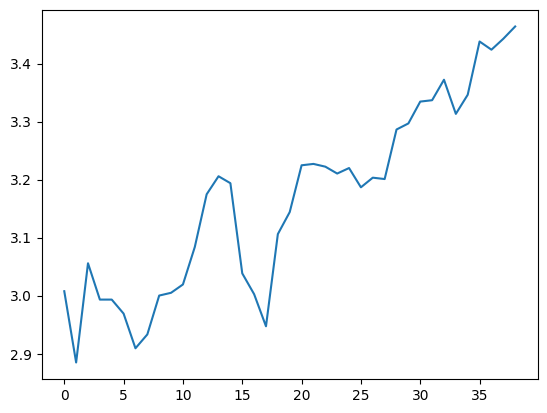

In [68]:
new_df[new_df.cfips==1001].microbusiness_density.plot()

In [ ]:
microbusiness_density

#### 6 countries

In [34]:
train_data.country.unique()

array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
      dtype=object)

#### 2 stores

In [35]:
train_data.store.unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

#### 4 products


In [36]:
train_data["product"].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

#### from 2017 to 2020

In [37]:
train_data["date"].unique()

array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', ...,
       '2020-12-29T00:00:00.000000000', '2020-12-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

## 3) Discover and visualize data to gain insights

#### There are no missing observations

In [38]:
train_data.isnull().sum()

date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [39]:
test_data.isnull().sum()

date       0
country    0
store      0
product    0
dtype: int64

In [40]:
train_data.describe()

num_sold
count  70128.000000
mean     194.296986
std      126.893874
min       19.000000
25%       95.000000
50%      148.000000
75%      283.000000
max      986.000000

#### Plot across countries, products and stores
##### First three patterns:
- KaggleRama sells always less than KaggleMart
- Some products are clearly sold more than others (in all countries): 'Kaggle for Kids: One Smart Goose' > 'Kaggle Advanced Techniques' > 'Kaggle Getting Started' > 'Kaggle Recipe Book'
- Number of items sold per country is similar although there are some differences (Belgium, France and Germany sell the most, while Italy, Spain and especially Poland report fewer sales)

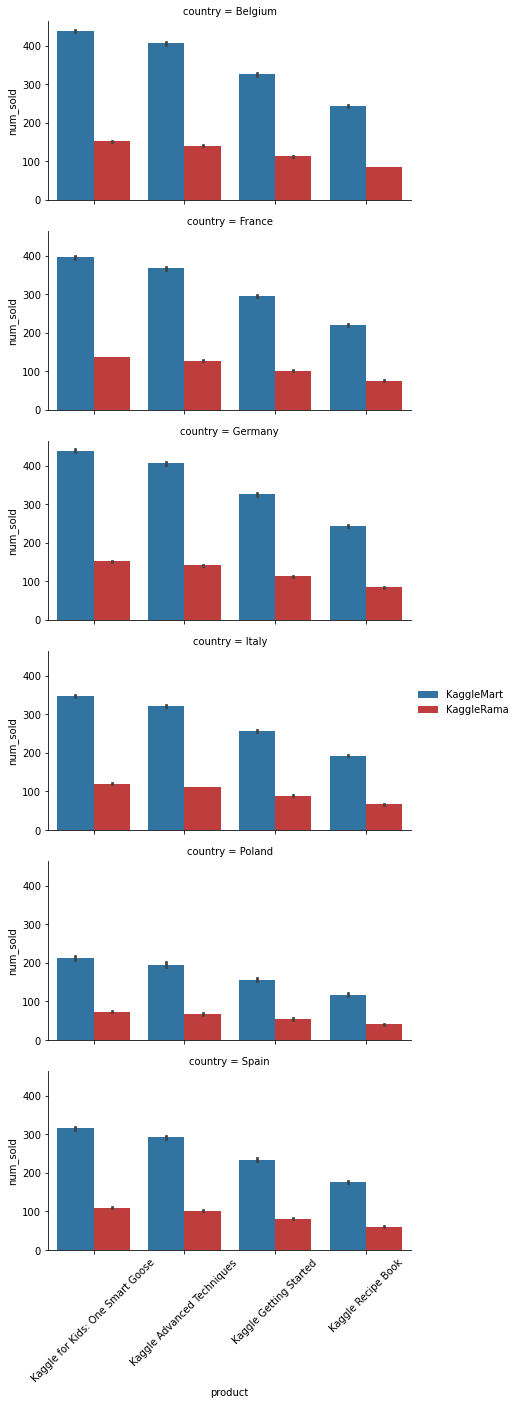

In [41]:
palette = ['tab:blue', 'tab:red']

g = sns.FacetGrid(train_data, row="country", height=3, aspect=2)
g.map(sns.barplot, "product", "num_sold",  order = ['Kaggle for Kids: One Smart Goose', 'Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book'], hue="store", data = train_data, palette =palette)
g.add_legend()
plt.xticks(rotation=45)
plt.show()

# g._legend.remove()
# plt.legend(title='Store')
# plt.show()

<AxesSubplot:xlabel='country', ylabel='num_sold'>

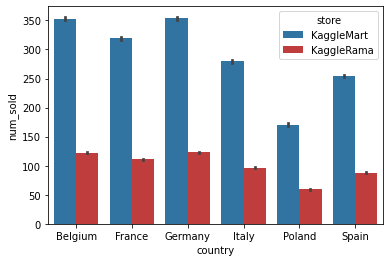

In [42]:
palette = ['tab:blue', 'tab:red']
sns.barplot(x = "country", y = "num_sold", hue="store", data = train_data, palette =palette)

#### Let's see the time series
- There is a strong seasonal/trend component for each product/store
- The trend and seasonality are not necessarily the same (for instance the trend of "Kaggle Getting Started" is moving in the opposite direction of "Kaggle Advanced Techniques" towards the end of the year
- There are some clear seasonal peaks around the 29/30th of December for all products categories
- Time series patterns seems similar in the two stores, despite the significant different in sales

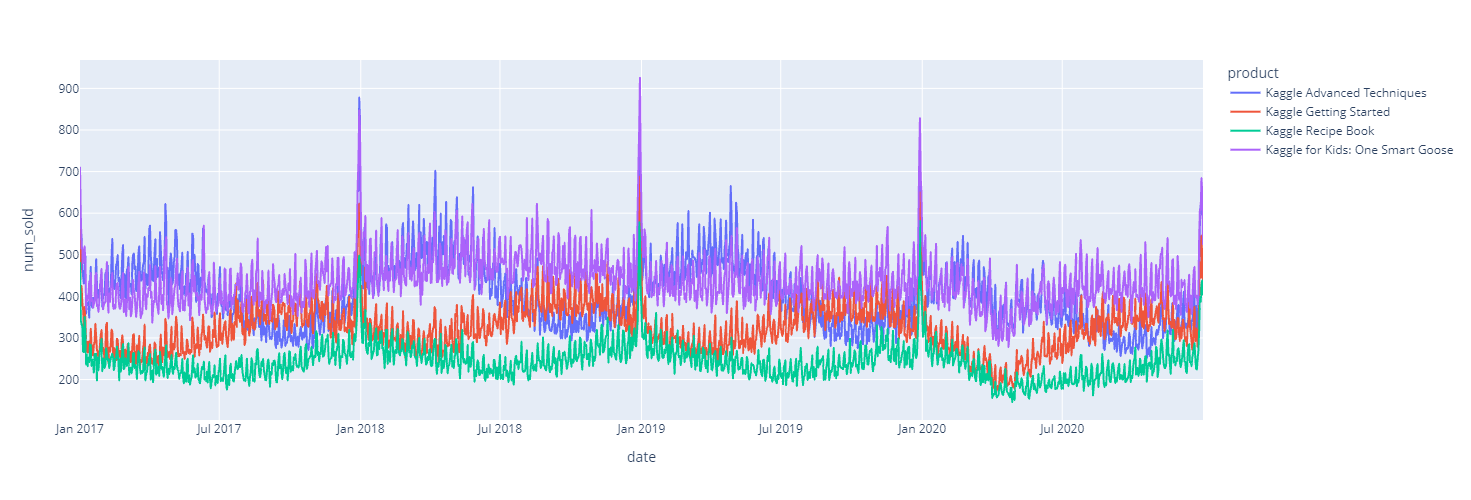

In [43]:
fig = px.line(train_data[(train_data.country=="Belgium") & (train_data.date>="2016-12-31") & (train_data.store=="KaggleMart")], x="date", y="num_sold", line_group="product", color="product")

fig.update_layout(
    autosize=True,
    width=1200,
    height=500,
)

- In 2020 the sales across countries become similar (break in the timeseries, especially for Poland, Spain and Italy)

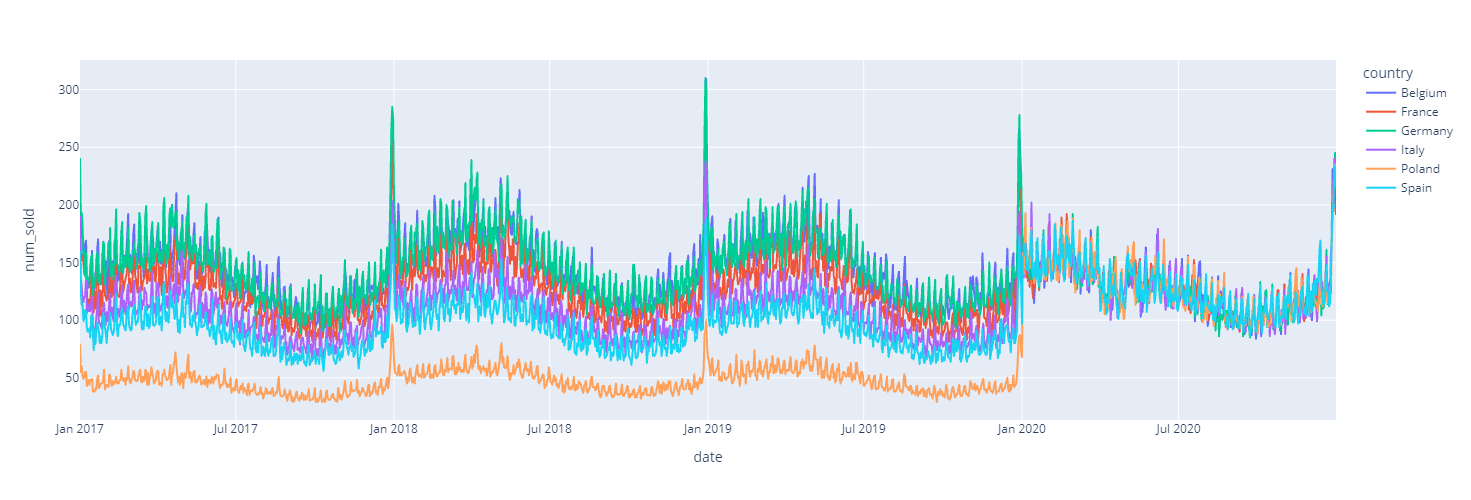

In [44]:
fig = px.line(train_data[(train_data["product"]=="Kaggle Advanced Techniques") & (train_data.date>="2016-12-31") & (train_data.store=="KaggleRama")], x="date", y="num_sold", line_group="country", color="country")

fig.update_layout(
    autosize=True,
    width=1000,
    height=500,
)

## 4) Feature engineering

In [45]:
# merge together train and test data
full = pd.concat([train_data,test_data])


In [46]:
#GDP queries from ECB SDW: Query: https://sdw.ecb.europa.eu/browseTable.do?org.apache.struts.taglib.html.TOKEN=50f080c05b59f1ffb0e4ce35c18fc53b&df=true&ec=&dc=&oc=&pb=&rc=&DATASET=0&removeItem=&removedItemList=&mergeFilter=&activeTab=MNA&showHide=&FREQ.249=Q&ADJUSTMENT.249=N&REF_AREA.249=BE&REF_AREA.249=DE&REF_AREA.249=ES&REF_AREA.249=FR&REF_AREA.249=IT&REF_AREA.249=PL&ACTIVITY.249=_Z&PRICES.249=V&MAX_DOWNLOAD_SERIES=500&SERIES_MAX_NUM=50&node=9683074&legendRef=reference&trans=N

countries = {"Germany":'DE','France':'FR','Belgium':'BE','Spain':'ES','Poland':'PL',"Italy":'IT'}

def create_features(df):
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofmonth'] = df.date.dt.day
    df['weekend'] = [True if a >=5 else False for a in df.dayofweek]
    df['quarter'] = df.date.dt.quarter
    df['week'] = df.date.dt.isocalendar().week.astype(int)
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['dayofyear'] = df.date.dt.dayofyear
    
    ## Add holidays info
    ls = []
    for country, date in zip(df['country'] , df.date):
        ls.append(date in holidays.country_holidays(countries[country]))
    df['isHoliday'] = ls
    
    ## Add approximate lockdown info
    df["lockdown"] = np.where((df["year"] == 2020) & (df["month"].isin([3,4,5,6])), True, False)
    
    ## Add cci, bci and quarterly GDP
    df_cci = pd.read_csv("data/tps2210_cci_2017_2021.csv")
    df_bci = pd.read_csv("data/tps2210_bci_2017_2021.csv")
    df_gdp = pd.read_csv("data/TPSSEP22_GDP_SDW.csv",delimiter= ";")
    
    ## GDP reformatting
    df_gdp.date = pd.to_datetime(df_gdp.date)+ pd.offsets.QuarterEnd(0)
    df_gdp["quarter"] = df_gdp.date.dt.quarter
    df_gdp["year"] = df_gdp.date.dt.year
    
    ## Merge dataframes
    df = df.merge(df_gdp[['country', 'year', 'quarter', 'gdp']], left_on=['country', 'year', 'quarter'], right_on=['country', 'year', 'quarter'],how='left')
    df = df.merge(df_bci[['country', 'year', 'month', 'bci']], left_on=['country', 'year', 'month'], right_on=['country', 'year', 'month'],how='left')
    df = df.merge(df_cci[['country', 'year', 'month', 'cci']], left_on=['country', 'year', 'month'], right_on=['country', 'year', 'month'],how='left')
    
    ## One hot enconding for countyr, store and product
    encoder = OneHotEncoder(variables=['country', 'store', 'product'], drop_last=True)
    df = encoder.fit_transform(df)
    df.index.names = ['row_id'] ## Ensure that row_id is still the indexs
    
    return df

full_enhanced=  create_features(full.copy())
train_df = create_features(train_data.copy())
test_df = create_features(test_data.copy())

In [47]:
full_enhanced.columns

Index(['date', 'num_sold', 'dayofweek', 'dayofmonth', 'weekend', 'quarter',
       'week', 'month', 'year', 'dayofyear', 'isHoliday', 'lockdown', 'gdp',
       'bci', 'cci', 'country_Belgium', 'country_France', 'country_Germany',
       'country_Italy', 'country_Poland', 'store_KaggleMart',
       'product_Kaggle Advanced Techniques', 'product_Kaggle Getting Started',
       'product_Kaggle Recipe Book'],
      dtype='object')

## 5) Create Model

#### Define the valuation method

In [48]:
def smape(actual,forecast):
    return 100/len(actual)* np.sum(2 * np.abs(forecast-actual)/(np.abs(actual)+ np.abs(forecast)))

#### Define a simple model and test it on a subset of the available data

In [49]:
FEATURES = ['dayofweek', 'dayofmonth', 'weekend', 'quarter',
       'week', 'month', 'year', 'dayofyear', 'isHoliday', 'country_Belgium',
       'country_France', 'country_Germany', 'country_Italy', 'country_Poland',
       'store_KaggleMart', 'product_Kaggle Advanced Techniques',
       'product_Kaggle Getting Started', 'product_Kaggle Recipe Book', 'cci', 'bci', 'gdp', 'lockdown']

TARGET = 'num_sold'

In [50]:
### Optimal parameters come from grid search below
optimal_parameters = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.5}

def validation_set(year, df, start=2017):
    start = f'01-01-{start}'
    train = df.loc[(df.date>=start) & (df.date < f'01-01-{year}')]
    val = df.loc[(df.date>=f'01-01-{year}') & (df.date<f'01-01-{year+1}')]
    test = df[df.num_sold.isna()==True]
    
    X_train,y_train = train[FEATURES], train[TARGET]
    X_test, y_test = val[FEATURES], val[TARGET]
    return  (X_train,y_train,X_test,y_test),val

def get_score(X_train, y_train,X_test,y_test):
    reg = xgb.XGBRegressor(eval_metric  = "mape",
                           **optimal_parameters)
    
    reg.fit(X_train,y_train)
    score = smape(y_test, reg.predict(X_test))
    print(f"Smape: {score:.3f}")
    return reg

data,val = validation_set(2020, train_df) ### For the extract df we use 2020 to assess the performance of the model
reg = get_score(*data)

[11:46:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:46:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Smape: 27.662


In [51]:
reg.get_xgb_params()

{'objective': 'reg:linear',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'mape',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 8,
 'max_leaves': 0,
 'min_child_weight': 4,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.5,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'nthread': 4,
 'silent': 1}

#### Let's visualize some predictions for 2020

In [52]:
val['prediction'] = reg.predict(data[2])

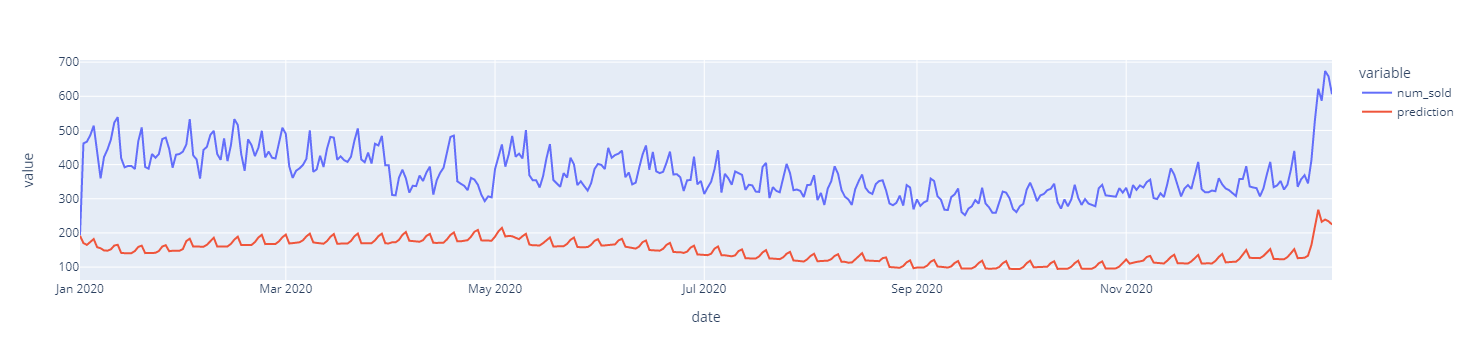

In [53]:
subset = val[(val.country_Poland==1) & (val.store_KaggleMart==1) & (val["product_Kaggle Advanced Techniques"]==1)]

px.line(subset, y = ['num_sold', 'prediction'], x = subset.date) 

#### Features importance

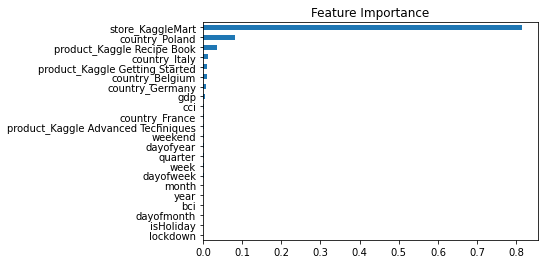

In [54]:
def get_importance(model):
    f1 = pd.DataFrame(data= model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=['importance'])
    f1.sort_values('importance').plot(kind='barh',title='Feature Importance',legend=False)
    plt.show()
    
get_importance(reg)    

## 6) GridSearch

In [55]:
## Various hyper-parameters to tune
#X_train = data[0]
#y_train = data[1]
#
#xgb1 = xgb.XGBRegressor()
#parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#              'objective':['reg:linear'],
#              'learning_rate': [0.01], #so called `eta` value
#              'max_depth': [8],
#              'min_child_weight': [4],
#              'silent': [1],
#              'subsample': [0.6, 0.7, 0.8, 0.9],
#              'colsample_bytree': [0.8],
#              'n_estimators': [800],
#              #'tree_method':['gpu_hist']
#             }
#
#xgb_grid = GridSearchCV(xgb1,
#                        parameters,
#                        cv = 2,
#                        n_jobs = 5,
#                        verbose=True)
#
#xgb_grid.fit(X_train,
#         y_train)
#
#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

## Ensembling

### Ridge regression - Kfold

In [59]:
def Ridge_predictions_kfold(df, optimal_parameters):
    
    test  = df[df['num_sold'].isna()]
    train = df[df['num_sold'].isna()==False]

    train = train.loc[train.date>='2017-01-01']
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    
    ridge_preds = np.zeros(X_test.shape[0])
    avg_smape = 0
    n=0

    kf = GroupKFold(n_splits=4)

    for trn_idx, test_idx in kf.split(X_train, groups=X_train.year) :
        x_train_fold, x_valid_fold = X_train.iloc[trn_idx], X_train.iloc[test_idx]
        y_train_fold, y_valid_fold = y_train.iloc[trn_idx], y_train.iloc[test_idx]

        ridge_model = Ridge(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=0, normalize=True)
        ridge_model.fit(x_train_fold, y_train_fold)

        y_pred = ridge_model.predict(x_valid_fold)
        avg_smape += smape(y_pred, y_valid_fold)

        n = n + 1

        test_pred = ridge_model.predict(X_test)
        #pred = pd.Series(test_pred) 

        ridge_preds += test_pred / kf.n_splits  
    
    test['num_sold'] = ridge_preds
    return test['num_sold'], ridge_model

ridge_predictions, ridge_model = Ridge_predictions_kfold(full_enhanced, "")

C:\Users\incar\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 

C:\Users\incar\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline im

### XGBoost

In [58]:
# From Grid search
optimal_parameters = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

def XGBoost_predictions(df, optimal_parameters):
    test  = df[df['num_sold'].isna()]
    train = df[df['num_sold'].isna()==False]

    train = train.loc[train.date>='2017-01-01']
    X_train = train[FEATURES]
    y_train = train[TARGET]

    reg = xgb.XGBRegressor(eval_metric  = "mape",
                           **optimal_parameters
                           )
    
    reg.fit(X_train,y_train)
    predictions = reg.predict(test[FEATURES])

    test['num_sold'] = predictions
    return test['num_sold'], reg

xgb_predictions, xgb_model = XGBoost_predictions(full_enhanced, optimal_parameters)

[11:51:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




## 7) Submission

In [68]:
final_prediction = xgb_predictions * 1 + ridge_predictions * 0

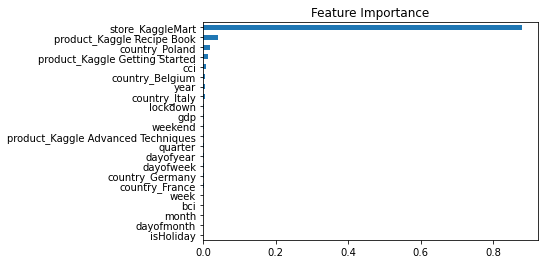

In [69]:
get_importance(xgb_model)

In [70]:
pd.concat([final_prediction]).to_csv('submissions/submission_12_xgb_ridge_ensambling_normalised.csv')

#Kaggle version
#pd.concat([final_prediction]).to_csv('submission_3_xgb_all_countries_together_from2017.csv')

## 8) Visualize final predictions

In [71]:
X_test = full_enhanced[full_enhanced['num_sold'].isna()].loc[:, full_enhanced.columns != 'num_sold']
merged_test = X_test.merge(final_prediction, left_index=True, right_index=True, how='inner')

In [72]:
full_predictions = full_enhanced.append(merged_test)
full_predictions["prediction_dummy"] = np.where(full_predictions.date >='2021-01-01', True, False)

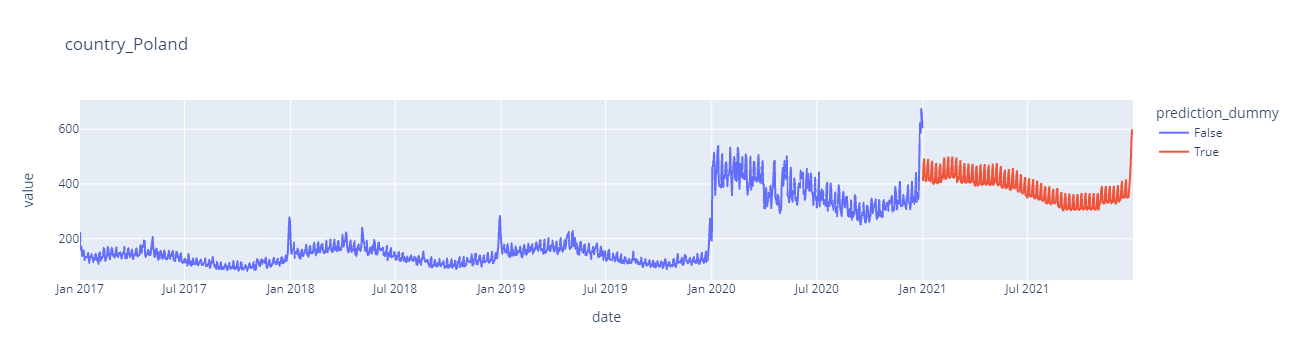

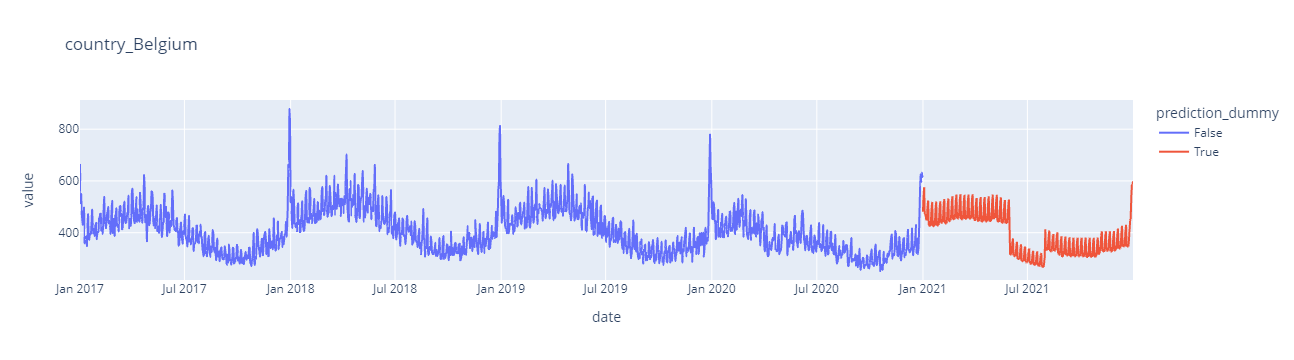

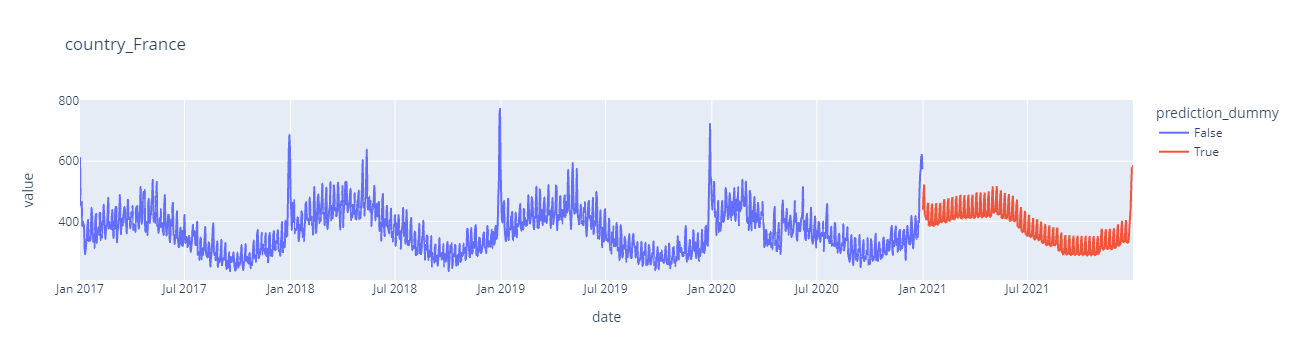

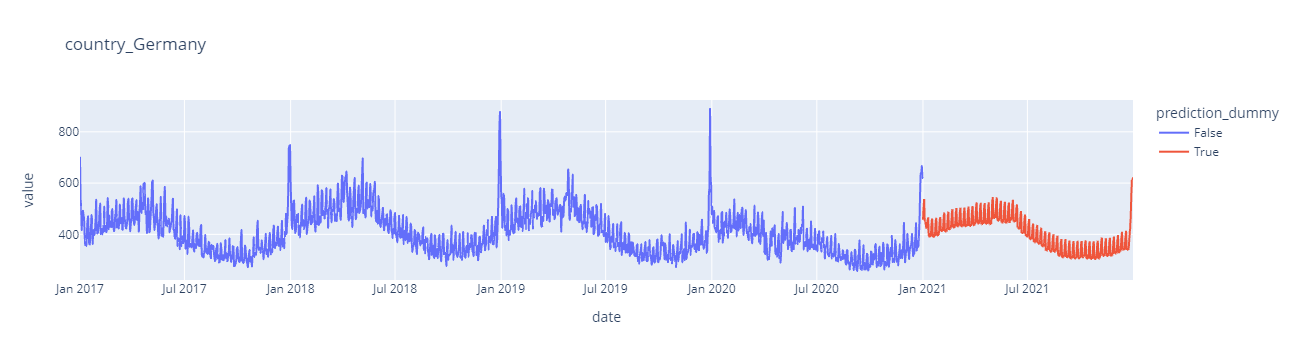

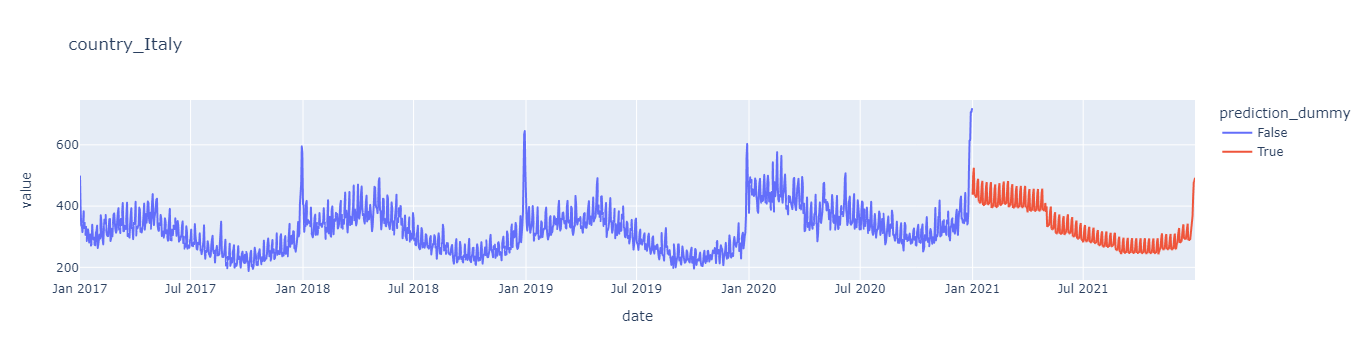

In [73]:
for country in ["country_Poland","country_Belgium","country_France", "country_Germany", "country_Italy"]:
    subset = full_predictions[(full_predictions[country]==1) & (full_predictions.store_KaggleMart==1) & (full_predictions["product_Kaggle Advanced Techniques"]==1)]
    fig = px.line(subset, y = ['num_sold'], x = subset.date, title=country, color=subset.prediction_dummy) 
    fig.show()

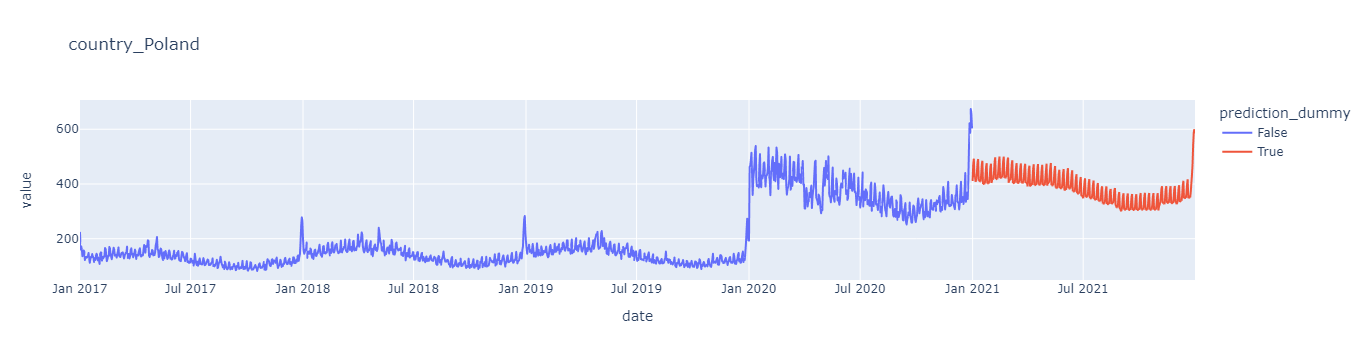

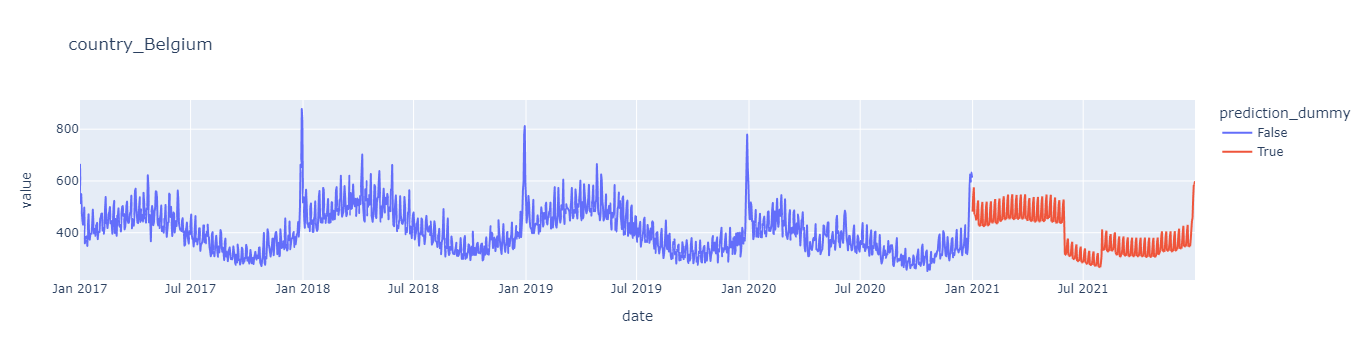

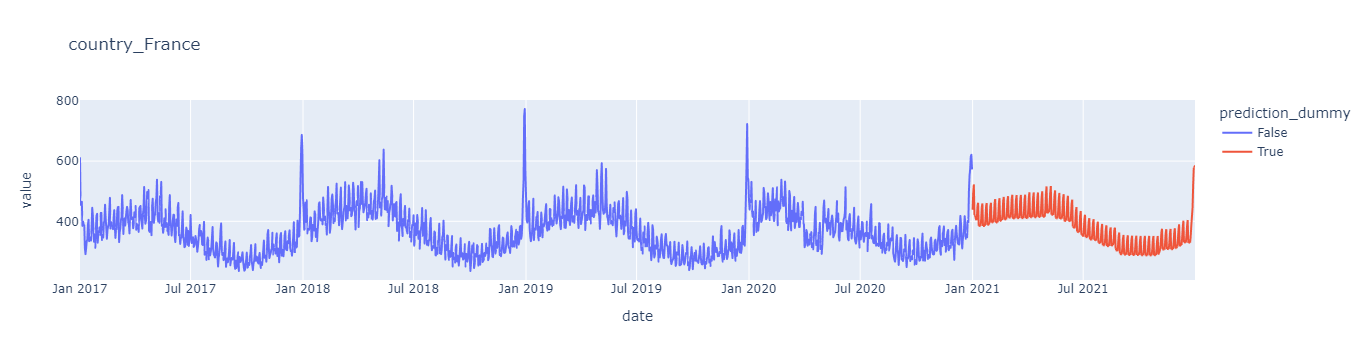

In [ ]:
for country in ["country_Poland","country_Belgium","country_France", "country_Germany", "country_Italy"]:
    subset = full_predictions[(full_predictions[country]==1) & (full_predictions.store_KaggleMart==1) & (full_predictions["product_Kaggle Advanced Techniques"]==1)]
    fig = px.line(subset, y = ['num_sold'], x = subset.date, title=country, color=subset.prediction_dummy) 
    fig.show()

## Notes-References
- List of holidays per country: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349549 and https://pypi.org/project/holidays/
- Sesonality and ts decomposition: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349986
- Create features - different times of the year: https://www.youtube.com/watch?v=vV12dGe_Fho&ab_channel=MedallionDataScience
- TPS 22 Sep - Review Time Series and Some Idea: https://www.kaggle.com/code/satoshiss/tps-22-sep-review-time-series-and-some-idea/comments
- XGBoost: A Complete Guide to Fine-Tune and Optimize your Model: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
- XGBoost Parameters: https://xgboost.readthedocs.io/en/latest/parameter.html
- Feature Engineering Ideas for This Contest: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/351098
- Ensambling: https://www.kaggle.com/code/saumilagrawal10/4-41-tpg-sep22-ensemble-of-models-improved
